# Netflixも使っている！Contextual Banditアルゴリズムを徹底解説！(Part 2)

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge as RR, LogisticRegression as LR
from sklearn.ensemble import GradientBoostingRegressor as GBR, GradientBoostingClassifier as GBC

from pandas import DataFrame
from plotly.offline import iplot, plot

In [3]:
from pymab.bandit import BernoulliBandit, GaussianBandit
from pymab.evaluation import DataGenerator, ReplayMethod, DirectMethod, IPSEstimator, DREstimator, MRDREstimator
from pymab.policy import EpsilonGreedy, UCB1, ThompsonSampling, GaussianThompsonSampling, LinUCB, LinTS
from pymab.sim import BanditSimulator

## Offline Evaluation用のデータ生成

In [4]:
n_arms, n_features = 10, 15
gb = GaussianBandit(n_arms=n_arms, n_features=n_features, scale=0.01, noise=0.01, contextual=True)
dg = DataGenerator(policy=LinUCB(n_arms=n_arms, n_features=n_features, alpha=1, batch_size=1), 
                   bandit=gb,
                   n_rounds=100000, 
                   randomized=True)

In [5]:
gb.params

array([[-1.37270667e-01, -9.63128772e-02,  8.87209023e-02,
        -1.00475592e-01,  8.72848073e-02,  3.04112360e-01,
        -4.57895232e-02,  1.16102527e-01,  9.18613711e-03,
         1.02393173e-01],
       [-2.74949098e-03, -1.08194532e-01, -1.67034350e-01,
         8.85467863e-02,  1.19795625e-01,  4.26285733e-02,
         1.10612983e-02, -3.85504674e-02,  7.73843676e-02,
        -1.10749467e-02],
       [-6.96305484e-02, -1.15083454e-01,  1.06799006e-01,
        -1.66756078e-01, -1.42090468e-03,  6.73856864e-02,
         1.63979250e-01, -3.18318238e-02, -3.87864591e-02,
         1.03666522e-02],
       [-1.09731577e-01, -2.64958134e-02,  1.42854106e-01,
         1.47924002e-01, -1.43909094e-02, -2.54790257e-02,
        -1.21947906e-01, -3.57902743e-02,  2.18962887e-01,
        -1.09541918e-01],
       [ 8.04051245e-02, -2.14115199e-01,  8.36486218e-02,
         8.36373349e-02, -5.42575686e-02, -1.25449035e-01,
        -9.91692301e-03, -1.77858080e-01, -1.83728468e-01,
         1.

In [6]:
data, a, r = dg.generate_data()

## Policy Candidates

In [7]:
pols =  [EpsilonGreedy(n_arms=n_arms, epsilon=0.2, batch_size=1),
         UCB1(n_arms=n_arms, batch_size=1),
         ThompsonSampling(n_arms=n_arms, batch_size=1),
         LinUCB(n_arms=n_arms, n_features=n_features, alpha=1, batch_size=1),
         LinTS(n_arms=n_arms, n_features=n_features, sigma=1, sample_batch=20, batch_size=1)]

## Replay Method

In [8]:
rm = ReplayMethod(policy_list=pols, n_iter=3)
result_rm = rm.estimate(data, a, r)
result_rm.describe()

EpsilonGreedy(ε=0.2)      UCB1  ThompsonSampling  LinUCB(α=1)  \
count              3.000000  3.000000          3.000000     3.000000   
mean               0.149683  0.130129          0.013438     0.335743   
std                0.001152  0.001677          0.002519     0.000964   
min                0.148978  0.128199          0.011048     0.334798   
25%                0.149018  0.129574          0.012124     0.335253   
50%                0.149059  0.130950          0.013200     0.335708   
75%                0.150035  0.131094          0.014634     0.336216   
max                0.151012  0.131238          0.016068     0.336724   

       LinTS(σ=1)  
count    3.000000  
mean     0.239337  
std      0.002107  
min      0.236959  
25%      0.238520  
50%      0.240080  
75%      0.240526  
max      0.240971

## Direct Method

In [9]:
dm = DirectMethod(policy_list=pols, n_iter=3, regression=True)
dm.fit(pom=GBR(n_estimators=100, max_depth=5, learning_rate=0.3), X=data, a=a, r=r)
result_dm = dm.estimate(data, a, r)
result_dm.describe()

EpsilonGreedy(ε=0.2)      UCB1  ThompsonSampling  LinUCB(α=1)  \
count              3.000000  3.000000          3.000000     3.000000   
mean               0.153725  0.177705          0.013685     0.345474   
std                0.000195  0.000175          0.000585     0.000132   
min                0.153506  0.177577          0.013043     0.345345   
25%                0.153647  0.177606          0.013434     0.345407   
50%                0.153787  0.177635          0.013824     0.345469   
75%                0.153834  0.177769          0.014006     0.345539   
max                0.153881  0.177904          0.014187     0.345609   

       LinTS(σ=1)  
count    3.000000  
mean     0.323742  
std      0.000332  
min      0.323484  
25%      0.323555  
50%      0.323627  
75%      0.323871  
max      0.324116

## IPS Estimator

In [ ]:
ips = IPSEstimator(policy_list=pols, n_iter=3)
ips.fit(pse=GBC(n_estimators=100, max_depth=5, learning_rate=0.3), 
        X=data, a=a)
result_ips = ips.estimate(data, a, r)
result_ips.describe()

## DR Estimator

In [ ]:
dr = DREstimator(policy_list=pols, n_iter=3, regression=True)
dr.fit(pom=GBR(n_estimators=100, max_depth=5, learning_rate=0.3), 
       pse=GBC(n_estimators=100, max_depth=5, learning_rate=0.3), 
       X=data, a=a, r=r)
result_dr = dr.estimate(data, a, r)
result_dr.describe()

## MRDR Estimator

In [ ]:
mrdr = MRDREstimator(policy_list=pols, n_iter=3, regression=True)
mrdr.fit(pom=GBR(n_estimators=100, max_depth=5, learning_rate=0.3), 
         pse=GBC(n_estimators=100, max_depth=5, learning_rate=0.3), 
         X=data, a=a, r=r)
result_mrdr = mrdr.estimate(data, a, r)
result_mrdr.describe()

## Online

In [13]:
gb_online = GaussianBandit(n_arms=n_arms, n_features=n_features, noise=0.1, contextual=True)
gb_online.params = gb.params

In [15]:
bs = BanditSimulator(policy_list=pols, 
                     bandit=gb_online, 
                     num_sims=5, n_rounds=10000, contextual=True)

In [16]:
bs.run_sim()

Avg Elapsed Time(10000 iter) EpsilonGreedy(ε=0.2) : 0.148s
Avg Elapsed Time(10000 iter) UCB1 : 0.201s
Avg Elapsed Time(10000 iter) ThompsonSampling : 0.192s
Avg Elapsed Time(10000 iter) LinUCB(α=1) : 0.64s
Avg Elapsed Time(10000 iter) LinTS(σ=1) : 0.68s


In [17]:
rewards_plot, regret_plot, bingo_plot = bs.plots()

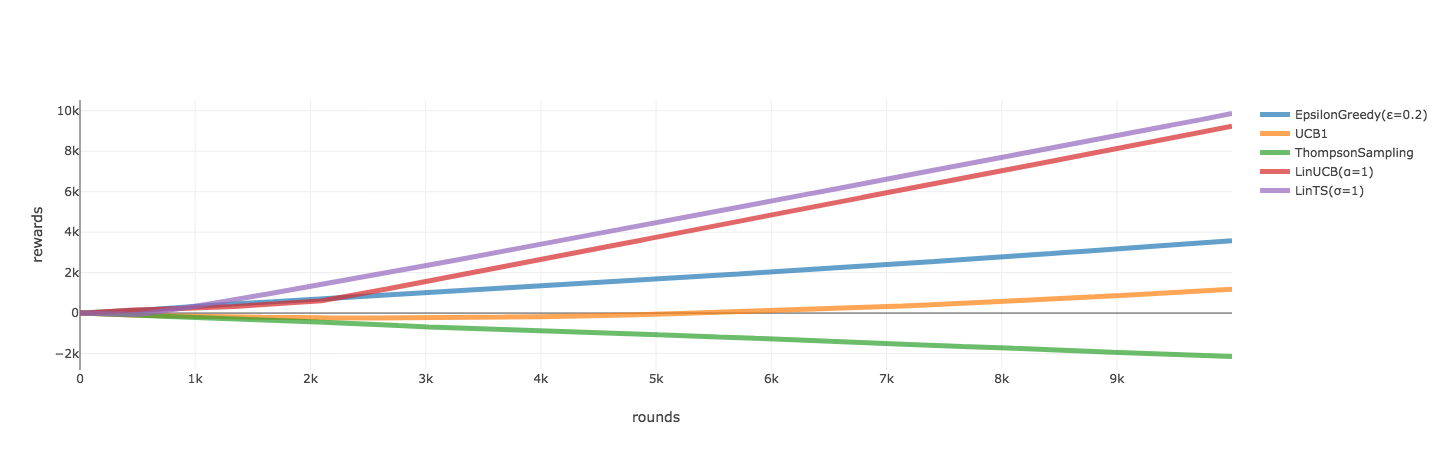

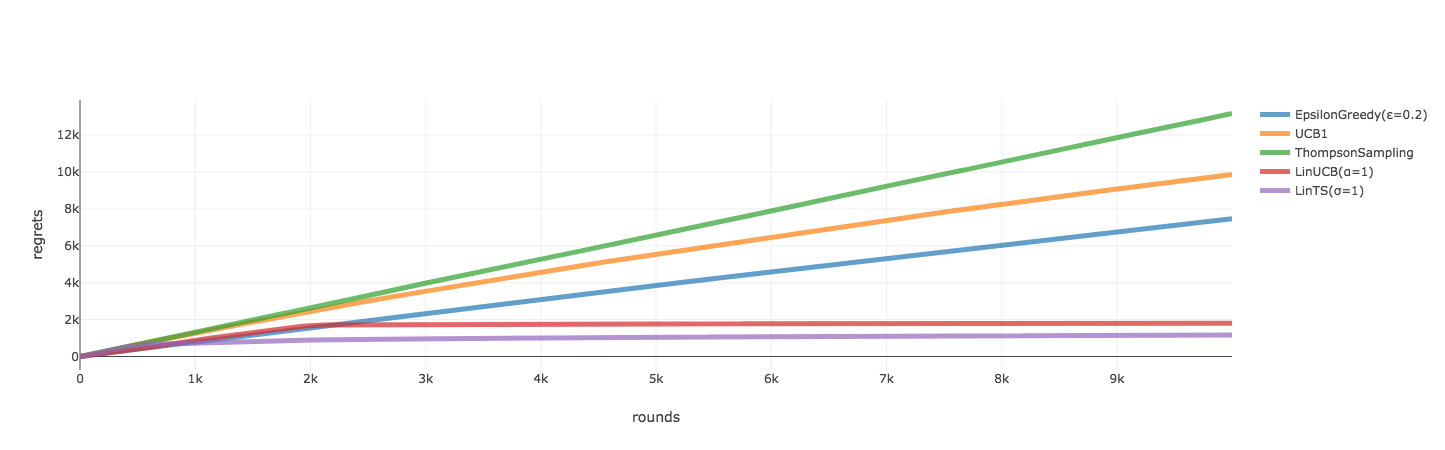

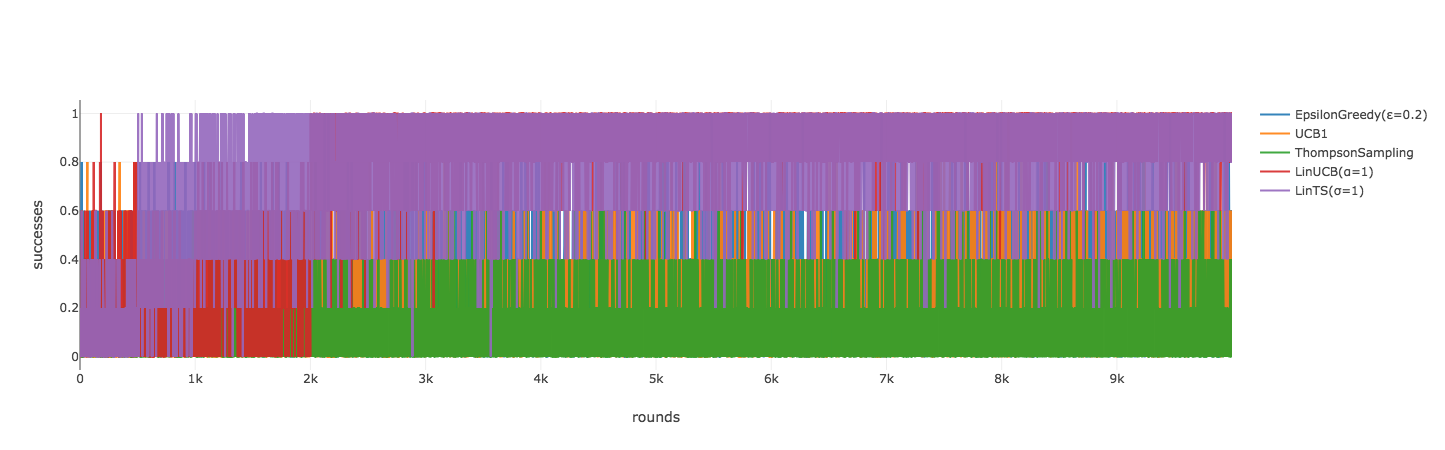

In [18]:
iplot(rewards_plot)
iplot(regret_plot)
iplot(bingo_plot)